In [1]:
import pandas as pd
df = pd.read_csv('SpotifyFeatures.csv')
df['popularity'] = df['popularity']/100

Text(0.5, 1.0, 'Correlation matrix for music features')

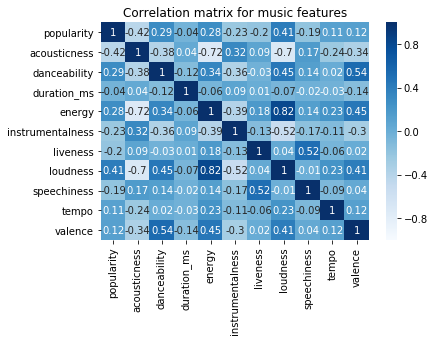

In [16]:
corr_df = df[['popularity', 
              'acousticness', 
              'danceability', 
              'duration_ms',
              'energy',
              'instrumentalness', 
              'liveness', 
              'loudness', 
              'speechiness',
              'tempo',
              'valence',
             ]].corr()
corr_df = corr_df.apply(lambda x: round(x, 2))
import seaborn as sns
sns.heatmap(corr_df, 
        xticklabels=corr_df.columns,
        yticklabels=corr_df.columns, vmax=1.0, vmin=-1.0, annot=True, cmap='Blues').set_title('Correlation matrix for music features')


In [2]:
df = pd.concat((df,pd.get_dummies(df['mode'])),1)
df = pd.concat((df,pd.get_dummies(df['key'])),1)
df = pd.concat((df,pd.get_dummies(df['time_signature'])),1)

In [3]:
df.head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,E,F,F#,G,G#,0/4,1/4,3/4,4/4,5/4
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,0.21,0.986,0.313,490867,0.23100,0.000431,...,0,0,0,0,0,0,0,0,1,0
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,0.18,0.972,0.360,176797,0.20100,0.028000,...,0,0,0,0,0,0,0,0,1,0
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,0.10,0.935,0.168,266184,0.47000,0.020400,...,0,0,0,0,0,0,0,1,0,0
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,0.17,0.961,0.250,288573,0.00605,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,0.19,0.985,0.142,629760,0.05800,0.146000,...,0,0,0,0,0,0,0,0,1,0


In [4]:
df = df.loc[:, df.columns != 'genre']
df = df.loc[:, df.columns != 'artist_name']
df = df.loc[:, df.columns != 'track_name']
df = df.loc[:, df.columns != 'track_id']
df = df.loc[:, df.columns != 'mode']
df = df.loc[:, df.columns != 'key']
df = df.loc[:, df.columns != 'time_signature']

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import numpy as np

df = df.sample(frac=1).reset_index(drop=True)

x_data = df.loc[:, df.columns != 'popularity']


y_data = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.1, random_state=0)

In [6]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))
print(mean_squared_error(knn.predict(X_test), y_test))

0.1823867565744849
0.02438155680224404


In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(lin_reg.score(X_test, y_test))
print(mean_squared_error(lin_reg.predict(X_test), y_test))

0.28446340569020456
0.021337589940637818


In [8]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=50,
                                     max_depth=None,
                                     )
random_forest.fit(X_train, y_train)
print(random_forest.score(X_test, y_test))
print(mean_squared_error(random_forest.predict(X_test), y_test))

0.6408588669680042
0.01070973349007354


In [9]:
import matplotlib.pyplot as plt

plt.bar(x_data.columns[np.argsort(random_forest.feature_importances_)[::-1][:10]], 
       random_forest.feature_importances_[np.argsort(random_forest.feature_importances_)[::-1][:10]])
plt.xlabel("Feature")
plt.xticks(rotation=60)
plt.title("Feature importances for random forest model")
plt.ylabel("Feature importance")
plt.savefig("feature_importances_random_forest.png")
plt.show()

<Figure size 640x480 with 1 Axes>

In [10]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
print(decision_tree.score(X_test, y_test))
print(mean_squared_error(decision_tree.predict(X_test), y_test))

0.3106968314887588
0.02055529859889639


In [11]:
# from sklearn.svm import LinearSVR
# svm = LinearSVR(C=1, max_iter=10000)
# svm.fit(X_train, y_train)
# print(svm.score(X_test, y_test))

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error)}

models = {"Linear_Regression": LinearRegression(),
          "KNN": KNeighborsRegressor(n_neighbors=2),
          "Random_Forest": RandomForestRegressor(n_estimators=50,
                                          max_depth=None,
                                          ),
          "Decision_Tree": DecisionTreeRegressor()
         }

R2_scores = []
RMSE_scores = []
for name, model in models.items():
    cv_scores = cross_validate(model, x_data, y_data, cv=10, n_jobs=2, scoring =scoring, return_train_score=False)
    print(f"{name} R2 score: {cv_scores['test_R2'].mean()}")
    print(f"{name} RMSE score: {cv_scores['test_MSE'].mean() ** (1/2)}")
    R2_scores.append(cv_scores['test_R2'].mean())
    RMSE_scores.append(cv_scores['test_MSE'].mean()** (1/2))

Linear_Regression R2 score: 0.28335559460551235
Linear_Regression RMSE score: 0.14624768113867762
KNN R2 score: 0.17824851579481438
KNN RMSE score: 0.15660127182084935


/home/sleonard8/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random_Forest R2 score: 0.6374027405668224
Random_Forest RMSE score: 0.10402802373325482
Decision_Tree R2 score: 0.3185159825550224
Decision_Tree RMSE score: 0.14261519663606284


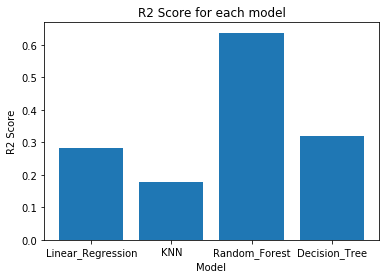

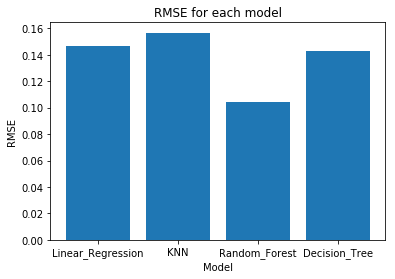

In [13]:
import matplotlib.pyplot as plt

plt.bar(models.keys(), R2_scores)
plt.xlabel("Model")
plt.title("R2 Score for each model")
plt.ylabel("R2 Score")
plt.savefig("r2_bar_plot.png")
plt.show()

plt.bar(models.keys(), RMSE_scores)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE for each model")

plt.savefig("rmse_bar_plot.png")
plt.show()